In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import os

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# Function to create data partitions
def create_data_partitions(dataset, num_partitions):
    # Get the number of samples in the dataset
    num_samples = len(dataset)

    # Calculate the number of samples per partition
    samples_per_partition = num_samples // num_partitions

    # Create a random permutation of indices to shuffle the dataset
    indices = np.random.permutation(num_samples)

    data_partitions = {}
    start_idx = 0

    # Create data partitions
    for i in range(num_partitions):
        end_idx = start_idx + samples_per_partition
        partition_indices = indices[start_idx:end_idx]

        # Subset the dataset using the partition indices
        partition_data = torch.utils.data.Subset(dataset, partition_indices)

        # Store the partition data in a dictionary
        data_partitions[f'node{i+1}'] = partition_data

        start_idx = end_idx

    return data_partitions

In [31]:
# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
images = train_dataset.data
labels = np.array(train_dataset.targets)
np.unique(labels, return_index=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([29,  4,  6,  9,  3, 27,  0,  7,  8,  1]))

In [33]:
num_partitions = 10

# Create data partitions
data_partitions_train = create_data_partitions(train_dataset, num_partitions)

# Example: Print the number of samples in each partition
for node_name, node_data in data_partitions_train.items():
    print(f"{node_name} - Number of samples: {len(node_data)}")

node1 - Number of samples: 5000
node2 - Number of samples: 5000
node3 - Number of samples: 5000
node4 - Number of samples: 5000
node5 - Number of samples: 5000
node6 - Number of samples: 5000
node7 - Number of samples: 5000
node8 - Number of samples: 5000
node9 - Number of samples: 5000
node10 - Number of samples: 5000


In [34]:
# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [35]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 64)
        out = self.relu3(self.fc1(out))
        out = self.fc2(out)
        return out
    

    

In [36]:
import random
import matplotlib.pyplot as plt

def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * (correct / total)
    return accuracy

def train_local_model(model, model_num, dataloader, testloader, criterion, optimizer, epoch_num, prev_accuracy, target_accuracy=80):
    model.train()
    for epoch in range(1):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        torch.save(model.state_dict(), f'/Users/jithinrajan/Desktop/NTU/FL/model_{model_num}_weights_{epoch_num}.pth')

        # Check accuracy after each epoch and break if target accuracy is reached
        accuracy = get_accuracy(model, testloader)
        print(f"Epoch {epoch_num+1}, Loss: {running_loss/len(testloader)}, Accuracy: {accuracy}, Node: {model_num}")
        # if accuracy >= target_accuracy:
        #     print(f"Target accuracy ({target_accuracy}%) achieved for node {epoch_num}.")
        #     break
        if abs(accuracy-prev_accuracy)<0.001:
            print(f'Further training will not improve accuracy.')
            break
    print("\n")
    return accuracy

def federated_learning(data_partitions, testloader, num_epochs, test_node, lr=0.001, target_accuracy=80):
    # models = [Model() for _ in range(10)]
    models = {}
    for i in range(10): 
        models[f'node{i+1}'] = Model()
    average_weights = None
    acc = [0 for _ in range(11)]
    accuracy_track = [[0 for _ in range(num_epochs)] for _ in range(11)]
    ep = 0

    for ep in range (num_epochs):
        model_num = 0
        for node_name, node_data in data_partitions.items():

            model_num+=1
            # Create DataLoader for each node's data
            node_dataloader = DataLoader(node_data, batch_size=32, shuffle=True)
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(models[node_name].parameters(), lr=lr)

            # Train local model at the current node
            acc[model_num-1] = train_local_model(models[node_name], model_num, node_dataloader, testloader, criterion, optimizer, ep, acc[model_num-1], target_accuracy=target_accuracy)
            accuracy_track[model_num-1][ep] = acc[model_num-1]

            models[node_name].load_state_dict(torch.load(f'/Users/jithinrajan/Desktop/NTU/FL/model_{model_num}_weights_{ep}.pth'))
            if average_weights is None:
                average_weights = models[node_name].state_dict()
            else:
                for key in average_weights:
                    average_weights[key] += models[node_name].state_dict()[key]
        
        seed = random.randint(1,10)
        print(f'Seed value for this averaging round is {seed}\n')
        
        for key in average_weights:
            average_weights[key] /= 10
        
        for node, model in models.items():
            model.load_state_dict(average_weights)

        for node, model in models.items():
            print(f'Accuracy after avg: {get_accuracy(model, testloader)}\n')
            break
        
        for i in range(10):
            checkpoint_filename = f'/Users/jithinrajan/Desktop/NTU/FL/model_{i+1}_weights_{ep}.pth'
            if os.path.exists(checkpoint_filename):
                os.remove(checkpoint_filename)

    # Initializing plot
    eps = [i+1 for i in range(num_epochs)]
    figure = plt.plot(eps, accuracy_track[test_node-1])
    plot = plt.title("Accuracy vs No. of Epochs", fontsize=20)
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.show()

Epoch 1, Loss: 3.7271597294867793, Accuracy: 42.42, Node: 1


Epoch 1, Loss: 3.6632761366759676, Accuracy: 39.24, Node: 2


Epoch 1, Loss: 3.776714570914643, Accuracy: 40.23, Node: 3


Epoch 1, Loss: 3.63713910609861, Accuracy: 42.309999999999995, Node: 4


Epoch 1, Loss: 3.6113017420225506, Accuracy: 42.309999999999995, Node: 5


Epoch 1, Loss: 3.63951805120782, Accuracy: 45.29, Node: 6


Epoch 1, Loss: 3.6645569937138616, Accuracy: 44.18, Node: 7


Epoch 1, Loss: 3.686877090719682, Accuracy: 44.56, Node: 8


Epoch 1, Loss: 3.661762195297434, Accuracy: 39.47, Node: 9


Epoch 1, Loss: 3.672528019434289, Accuracy: 42.78, Node: 10


Seed value for this averaging round is 3

Accuracy after avg: 10.97

Epoch 2, Loss: 3.909405512145803, Accuracy: 35.78, Node: 1


Epoch 2, Loss: 3.8509245280978046, Accuracy: 35.9, Node: 2


Epoch 2, Loss: 3.9188339182093173, Accuracy: 33.14, Node: 3


Epoch 2, Loss: 3.8868864186202425, Accuracy: 29.9, Node: 4


Epoch 2, Loss: 3.9088125832473177, Accuracy: 39

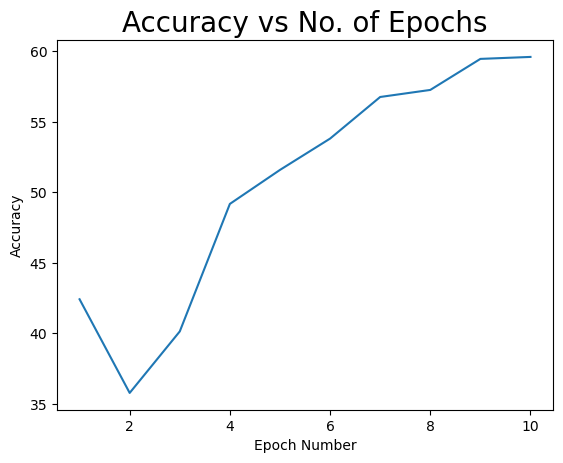

In [37]:
federated_learning(data_partitions_train, test_loader, num_epochs=10, test_node=1, lr=0.001, target_accuracy=80)

In [38]:
import random
def poison(data_partitions_train, set_number, num_changes=1000):
    node_num = "node" + str(set_number)
    node_data = data_partitions_train[node_num]

    for img, lbl in data_partitions_train[node_num]:
        # Generating random indices to be changed
        # random_indices = [random.randint(0,4999) for _ in range(num_changes)]
        # for i in random_indices:
        shift = random.randint(1,9)
        modified_label =  (lbl + shift) % 10

        # Printing the original label, shift and the modified label
        print(f'label: {lbl}, shift: {shift}, new: {modified_label}')

        # Old label is replaced with the new label
        lbl = modified_label

    print(f'Percentage of data poisoned at {node_num} is {num_changes*100/5000}%')

In [39]:
poison(data_partitions_train, set_number=1, num_changes=5000)

label: 1, shift: 4, new: 5
label: 7, shift: 9, new: 6
label: 9, shift: 8, new: 7
label: 7, shift: 7, new: 4
label: 3, shift: 1, new: 4
label: 4, shift: 7, new: 1
label: 1, shift: 4, new: 5
label: 2, shift: 6, new: 8
label: 5, shift: 9, new: 4
label: 6, shift: 3, new: 9
label: 8, shift: 6, new: 4
label: 6, shift: 4, new: 0
label: 3, shift: 5, new: 8
label: 7, shift: 2, new: 9
label: 9, shift: 7, new: 6
label: 4, shift: 2, new: 6
label: 5, shift: 4, new: 9
label: 0, shift: 9, new: 9
label: 3, shift: 4, new: 7
label: 7, shift: 1, new: 8
label: 3, shift: 7, new: 0
label: 3, shift: 8, new: 1
label: 9, shift: 7, new: 6
label: 8, shift: 2, new: 0
label: 8, shift: 3, new: 1
label: 5, shift: 7, new: 2
label: 9, shift: 8, new: 7
label: 9, shift: 4, new: 3
label: 4, shift: 1, new: 5
label: 9, shift: 1, new: 0
label: 2, shift: 5, new: 7
label: 7, shift: 3, new: 0
label: 2, shift: 9, new: 1
label: 8, shift: 6, new: 4
label: 9, shift: 5, new: 4
label: 4, shift: 2, new: 6
label: 0, shift: 4, new: 4
l

In [40]:
poison(data_partitions_train, set_number=2, num_changes=5000)

label: 4, shift: 8, new: 2
label: 4, shift: 6, new: 0
label: 8, shift: 3, new: 1
label: 8, shift: 1, new: 9
label: 4, shift: 8, new: 2
label: 9, shift: 8, new: 7
label: 1, shift: 6, new: 7
label: 7, shift: 3, new: 0
label: 3, shift: 3, new: 6
label: 6, shift: 8, new: 4
label: 1, shift: 6, new: 7
label: 2, shift: 9, new: 1
label: 1, shift: 3, new: 4
label: 1, shift: 5, new: 6
label: 3, shift: 8, new: 1
label: 4, shift: 2, new: 6
label: 8, shift: 3, new: 1
label: 4, shift: 5, new: 9
label: 8, shift: 5, new: 3
label: 8, shift: 6, new: 4
label: 4, shift: 2, new: 6
label: 8, shift: 3, new: 1
label: 0, shift: 6, new: 6
label: 3, shift: 8, new: 1
label: 3, shift: 6, new: 9
label: 8, shift: 2, new: 0
label: 3, shift: 4, new: 7
label: 7, shift: 2, new: 9
label: 9, shift: 6, new: 5
label: 7, shift: 7, new: 4
label: 6, shift: 3, new: 9
label: 9, shift: 9, new: 8
label: 4, shift: 5, new: 9
label: 1, shift: 1, new: 2
label: 1, shift: 8, new: 9
label: 7, shift: 8, new: 5
label: 9, shift: 9, new: 8
l

Epoch 1, Loss: 3.770707169665566, Accuracy: 41.82, Node: 1


Epoch 1, Loss: 3.7587970133069195, Accuracy: 41.8, Node: 2


Epoch 1, Loss: 3.743266864667965, Accuracy: 36.03, Node: 3


Epoch 1, Loss: 3.6613555920274954, Accuracy: 44.15, Node: 4


Epoch 1, Loss: 3.7213047063803373, Accuracy: 38.440000000000005, Node: 5


Epoch 1, Loss: 3.7643652399883996, Accuracy: 40.62, Node: 6


Epoch 1, Loss: 3.7225276744818387, Accuracy: 41.21, Node: 7


Epoch 1, Loss: 3.6010288618787936, Accuracy: 43.04, Node: 8


Epoch 1, Loss: 3.637433670744111, Accuracy: 42.230000000000004, Node: 9


Epoch 1, Loss: 3.6668423897103417, Accuracy: 41.099999999999994, Node: 10


Seed value for this averaging round is 10

Accuracy after avg: 10.0

Epoch 2, Loss: 3.934526081326642, Accuracy: 38.190000000000005, Node: 1


Epoch 2, Loss: 3.890142682232434, Accuracy: 36.3, Node: 2


Epoch 2, Loss: 3.903212962271292, Accuracy: 35.339999999999996, Node: 3


Epoch 2, Loss: 3.918663150147547, Accuracy: 36.55, Node: 4


Epoch 

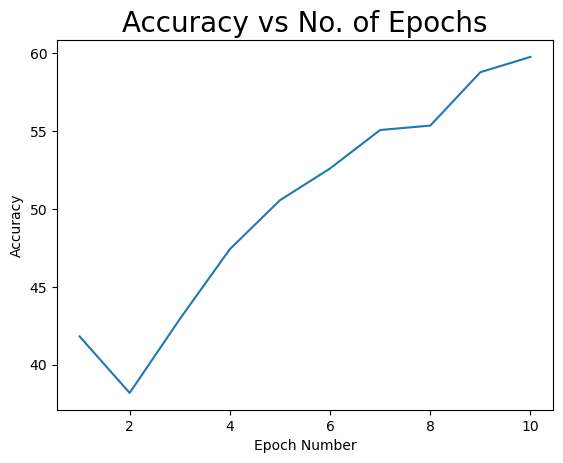

In [41]:
federated_learning(data_partitions_train, test_loader, num_epochs=10, test_node=1, lr=0.001, target_accuracy=80)

In [ ]:
from collections import defaultdict
import networkx as nx

class Graph:
    def __init__(self):
        self.graph = defaultdict(list)
        self.node_values = {}
    
    def add_edge(self, u, v, weight):
        self.graph[u].append((v, weight))
        self.graph[v].append((u, weight))

    def connection(self, node1, node2): 
        neighbors = self.graph[node1]
        for v, weight in neighbors:
            if node2==v:
                return True
        return False
    
    def set_node(self, node, value):
        self.node_values[node] = value
    
    def get_node(self, node):
        return self.node_values[node]
        
    def push(self, node, value):
        self.set_node(node, value)
        neighbors = self.graph[node]
        for neighbor, weight in neighbors:
            self.pull(neighbor, value, weight)

    def pull(self, node, value, weight):
        current_value = self.get_node(node)
        if current_value is None or value * weight > current_value:
            self.set_node(node, value * weight)
            neighbors = self.graph[node]
            for neighbor, neighbor_weight in neighbors:
                self.pull(neighbor, value + weight, neighbor_weight)
    
    def pull1(self, node):
        current_value = self.get_node(node)
        if current_value is None:
            return 
        neighbors = self.graph[node]
        for neighbor, weight in neighbors:
            neighbor_value = self.get_node(neighbor)
            if neighbor_value is not None:
                self.set_node(neighbor, neighbor_value + weight)
                self.pull1(neighbor)

    def betweenness_centrality(self):
        G = nx.Graph(self.graph)
        betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
        return betweenness_centrality

    def __str__(self):
        graph_str = ""
        for node in self.graph:
            neighbors = self.graph[node]
            neighbors_str = ", ".join([f"{v}:{weight}" for v, weight in neighbors])
            value = self.node_values.get(node)
            graph_str += f"{node}:{value} -> {neighbors_str}\n"
        return graph_str 


In [ ]:
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def createGraph(graph, nodes, num):
    for i in range(0,num):
        index1 = random.randint(0,9)
        index2 = random.randint(0,9)
        if (index1==index2):
            continue
        if (g.connection(nodes[index1], nodes[index2])==True):
            continue
        weight = random.randint(1,5)
        graph.add_edge(nodes[index1], nodes[index2], weight)


In [ ]:
g = Graph()
createGraph(g, nodes, num=15)

In [ ]:
st = g.__str__()
print(st)

In [ ]:
# Calculate betweenness centrality
betweenness_centrality = g.betweenness_centrality()

# Print betweenness centrality values
print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")

In [ ]:
# Create a graph
g = Graph()

# Add edges and their weights
g.add_edge('A', 'B', 5)
g.add_edge('B', 'C', 3)
g.add_edge('B', 'D', 2)
g.add_edge('D', 'A', 4)

# Set values for nodes
g.set_node('A', 100)
g.set_node('B', 200)
g.set_node('C', 300)
g.set_node('D', 400)

# Get values for nodes
print(g.get_node('A'))
print(g.get_node('B'))
print(g.get_node('C'))
print(g.get_node('D'))

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# Create a dense matrix
dense_matrix = np.array([[1, 0, 0],
                         [0, 0, 2],
                         [3, 0, 4]])

# Convert the dense matrix to a CSR sparse matrix
sparse_csr = csr_matrix(dense_matrix)

print(sparse_csr)
